<a href="https://colab.research.google.com/github/Madara123455/Energy-DA-for-Petroleum/blob/main/Water_Saturation_Profiling_in_Layered_Reservoirs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

### Problem Statement
>  A four-layer oil reservoir is characterized by a set of reservoir capillary
 pressure-saturation curves as shown in Figure 4-16. The following additional data are also available.

In [3]:
# Importing Data of Layered Reservoirs:
dict = {"Layer":[1,2,3,4],"Depth (in ft)": ["4000-4010","4010-4020","4020-4035","4035-4060"],"Permeability (in md)":[80,90,70,100]}
df_1 = pd.DataFrame(dict)
df_1['Top']  = df_1['Depth (in ft)'].str.split('-').str[0].astype(int)
df_1['Bottom']  = df_1['Depth (in ft)'].str.split('-').str[1].astype(int)
df_1

,Layer,Depth (in ft),Permeability (in md),Top,Bottom
0,1,4000-4010,80,4000,4010
1,2,4010-4020,90,4010,4020
2,3,4020-4035,70,4020,4035
3,4,4035-4060,100,4035,4060


In [4]:
WOC = int(input("Enter Depth of Water-Oil Contact :"))
D_w = float(input("Enter Density of water (in lb/ft^3) :"))
D_o = float(input("Enter Density of oil (in lb/ft^3) :"))

Enter Depth of Water-Oil Contact :4060
Enter Density of water (in lb/ft^3) :65.2
Enter Density of oil (in lb/ft^3) :55.2


### Aim

> Calculate and plot water saturation versus depth for this reservoir.



### Procedure #

1. We will firstly find Free-Water Level (FWL) using the following formula:

$$ FWL = WOC + \frac{144(P_{d})}{\Delta D} $$

$$ P_{d}\:\:\:is\:\:\:Displacement\:\:\:Pressure $$

$$ Where\:\:\:\Delta D = D_{w} - D_{o}$$

2. Then we will calculate  Pc from the following formula :

$$ P_{c} = \frac{(\Delta D)\:X\:h}{144}$$

            Where h is height above the Free Water level
3. Find Corrosponding Sw ( water saturation ) from the Capillary Pressure - Saturation Curve for Respective Permeability ; vary that Sw to top of layer and bottom of layer and find h ( height above FWL ) from the following formula until layer 1 is completed .

> $$ h = \frac{(144)\:X\:P_{c}}{\Delta D}$$

4.  Repeat this process for several Layers ( 1,2,3,4 or more ) and plot
  h v/s Sw

5. And this gives us a proper idea at what depth one should drill , if there is some sought of a Transition zone present ( both oil and water will get produced ) , So we have to drill when Curve Asymptotes on the line x = Srw ( ireducable water saturation ) . That is above Transition zone and below GOC ( Gas Oil contact ) /




In [7]:
# Importing Capillary Pressure v/s Water Saturation data with different permeability :

data = pd.read_csv('/content/Layered_reservoir_dataset.csv')
df = pd.DataFrame(data)
df.columns = df.columns.str.strip()
df.head()

,Sw_1,Pc_1,Sw_2,Pc_2,Sw_3,Pc_3,Sw_4,Pc_4
0,0.248,5.031,0.198,5.031,0.301,5.030,0.148,5.049
1,0.248,4.894,0.198,4.741,0.301,4.911,0.148,4.913
2,0.248,4.741,0.198,4.332,0.301,4.757,0.148,4.742
3,0.248,4.587,0.198,3.957,0.301,4.518,0.148,4.554
4,0.248,4.400,0.198,3.752,0.301,4.314,0.148,4.298


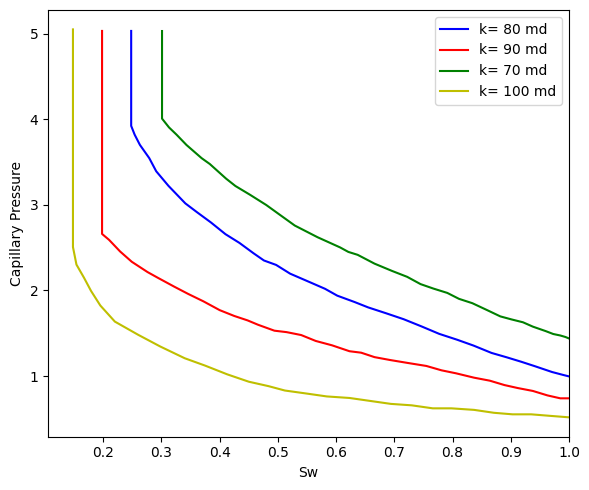

In [8]:
plt.figure(figsize=(6,5))
plt.plot(df['Sw_1'],df['Pc_1'] , color = 'b', label = 'k= 80 md')
plt.plot(df['Sw_2'],df['Pc_2'] , color = 'r', label = 'k= 90 md')
plt.plot(df['Sw_3'],df['Pc_3'] , color = 'g', label = 'k= 70 md')
plt.plot(df['Sw_4'],df['Pc_4'] , color = 'y', label = 'k= 100 md')
plt.xlabel('Sw')
plt.ylabel('Capillary Pressure')
plt.xlim(right=1)
plt.tight_layout()
plt.legend()
plt.show()


In [9]:
# Calculating FWL (Free Water Level):
# But first let us find Pd (Displacement pressure for Bottom Layer)
Pd = 0
for i in range(len(df)):
  if df['Sw_4'][i] == 1.000:
    Pd = df['Pc_4'][i]
    break
FWL = WOC + (144*float(Pd))/(D_w - D_o)
FWL

4067.4592

In [10]:
h_u_l4 = (FWL - df_1['Top'][3]).astype(float)     # height of top of layer 4 from FWL
h_b_l4 = (FWL - df_1['Bottom'][3]).astype(float)  # height of bottom layer 4 from FWL

Pc_u_l4 = (D_w - D_o)*(h_u_l4)/(144)
Pc_b_l4 = (D_w - D_o)*(h_b_l4)/(144)

df_clean = pd.DataFrame({'Pc': np.array(df["Pc_4"]), 'Sw': np.array(df["Sw_4"])}).dropna()

# Step 3: Group by Pc to ensure no duplicates (take mean Sw for same Pc)
df_grouped = df_clean.groupby('Pc', as_index=False).mean()

# Step 4: Sort by Pc
df_sorted = df_grouped.sort_values('Pc')

# Step 5: Interpolate Sw for given Pc_4 = 2.25

Sw_u_l4 = np.interp(Pc_u_l4, df_sorted['Pc'], df_sorted['Sw'])
Sw_b_l4 = np.interp(Pc_b_l4, df_sorted['Pc'], df_sorted['Sw'])

Sw_4 = np.linspace(Sw_u_l4, Sw_b_l4 , 20)

pc_range_layer_4 = np.array([])
h_range_layer_4 = np.array([])
df_sorted = (df_clean.groupby('Sw', as_index=False).mean()).sort_values('Sw')

for i in range(len(Sw_4)):
  pc_range_layer_4 = np.append(pc_range_layer_4, np.interp(Sw_4[i],df_sorted['Sw'], df_sorted['Pc']))

for i in range(len(pc_range_layer_4)):
  h_range_layer_4 = np.append(h_range_layer_4,round((144*float(pc_range_layer_4[i]))/(D_w - D_o),2))

dict = {"Sw_4" : Sw_4 , "Pc_4" : pc_range_layer_4 , "h_4" : h_range_layer_4}
df_4 = pd.DataFrame(dict)
df_4['Depth'] = FWL - df_4['h_4']
df_4.head()

,Sw_4,Pc_4,h_4,Depth
0,0.158043,2.254111,32.46,4034.9992
1,0.202356,1.768682,25.47,4041.9892
2,0.246670,1.533322,22.08,4045.3792
3,0.290983,1.370297,19.73,4047.7292
4,0.335297,1.223342,17.62,4049.8392


In [11]:
h_u_l3 = (FWL - df_1['Top'][2]).astype(float)     # height of top of layer 4 from FWL
h_b_l3 = (FWL - df_1['Bottom'][2]).astype(float)  # height of bottom layer 4 from FWL

Pc_u_l3 = (D_w - D_o)*(h_u_l3)/(144)
Pc_b_l3 = (D_w - D_o)*(h_b_l3)/(144)

df_clean = pd.DataFrame({'Pc': np.array(df["Pc_3"]), 'Sw': np.array(df["Sw_3"])}).dropna()

# Step 3: Group by Pc to ensure no duplicates (take mean Sw for same Pc)
df_grouped = df_clean.groupby('Pc', as_index=False).mean()

# Step 4: Sort by Pc
df_sorted = df_grouped.sort_values('Pc')

# Step 5: Interpolate Sw for given Pc_4 = 2.25

Sw_u_l3 = np.interp(Pc_u_l3, df_sorted['Pc'], df_sorted['Sw'])
Sw_b_l3 = np.interp(Pc_b_l3, df_sorted['Pc'], df_sorted['Sw'])

Sw_3 = np.linspace(Sw_u_l3, Sw_b_l3 , 20)

pc_range_layer_3 = np.array([])
h_range_layer_3 = np.array([])
df_sorted = (df_clean.groupby('Sw', as_index=False).mean()).sort_values('Sw')

for i in range(len(Sw_3)):
  pc_range_layer_3 = np.append(pc_range_layer_3, np.interp(Sw_3[i],df_sorted['Sw'], df_sorted['Pc']))

for i in range(len(pc_range_layer_3)):
  h_range_layer_3 = np.append(h_range_layer_3,round((144*float(pc_range_layer_3[i]))/(D_w - D_o),2))

In [16]:
h_u_l2 = (FWL - df_1['Top'][1]).astype(float)     # height of top of layer 4 from FWL
h_b_l2 = (FWL - df_1['Bottom'][1]).astype(float)  # height of bottom layer 4 from FWL

Pc_u_l2 = (D_w - D_o)*(h_u_l2)/(144)
Pc_b_l2 = (D_w - D_o)*(h_b_l2)/(144)

df_clean = pd.DataFrame({'Pc': np.array(df["Pc_2"]), 'Sw': np.array(df["Sw_2"])}).dropna()

# Step 3: Group by Pc to ensure no duplicates (take mean Sw for same Pc)
df_grouped = df_clean.groupby('Pc', as_index=False).mean()

# Step 4: Sort by Pc
df_sorted = df_grouped.sort_values('Pc')

# Step 5: Interpolate Sw for given Pc_4 = 2.25

Sw_u_l2 = np.interp(Pc_u_l2, df_sorted['Pc'], df_sorted['Sw'])
Sw_b_l2 = np.interp(Pc_b_l2, df_sorted['Pc'], df_sorted['Sw'])

Sw_2 = np.linspace(Sw_u_l2, Sw_b_l2 , 20)

pc_range_layer_2 = np.array([])
h_range_layer_2 = np.array([])
df_sorted = (df_clean.groupby('Sw', as_index=False).mean()).sort_values('Sw')

for i in range(len(Sw_2)):
  pc_range_layer_2 = np.append(pc_range_layer_2, np.interp(Sw_2[i],df_sorted['Sw'], df_sorted['Pc']))

for i in range(len(pc_range_layer_4)):
  h_range_layer_2 = np.append(h_range_layer_2,round((144*float(pc_range_layer_2[i]))/(D_w - D_o),2))

In [17]:
h_u_l1 = (FWL - df_1['Top'][0]).astype(float)     # height of top of layer 4 from FWL
h_b_l1 = (FWL - df_1['Bottom'][0]).astype(float)  # height of bottom layer 4 from FWL

Pc_u_l1 = (D_w - D_o)*(h_u_l1)/(144)
Pc_b_l1 = (D_w - D_o)*(h_b_l1)/(144)

df_clean = pd.DataFrame({'Pc': np.array(df["Pc_1"]), 'Sw': np.array(df["Sw_1"])}).dropna()

# Step 3: Group by Pc to ensure no duplicates (take mean Sw for same Pc)
df_grouped = df_clean.groupby('Pc', as_index=False).mean()

# Step 4: Sort by Pc
df_sorted = df_grouped.sort_values('Pc')

# Step 5: Interpolate Sw for given Pc_4 = 2.25

Sw_u_l1 = np.interp(Pc_u_l1, df_sorted['Pc'], df_sorted['Sw'])
Sw_b_l1 = np.interp(Pc_b_l1, df_sorted['Pc'], df_sorted['Sw'])
Sw_u_l1 , Sw_b_l1 , Pc_u_l1 , Pc_b_l1
Sw_1 = np.linspace(Sw_u_l1, Sw_b_l1 , 20)

pc_range_layer_1 = np.array([])
h_range_layer_1 = np.array([])
df_sorted = (df_clean.groupby('Sw', as_index=False).mean()).sort_values('Sw')

for i in range(len(Sw_1)):
    pc_range_layer_1 = np.append(pc_range_layer_1, np.interp(Sw_1[i],df_sorted['Sw'], df_sorted['Pc']))

for i in range(len(pc_range_layer_1)):
    h_range_layer_1 = np.append(h_range_layer_1,round((144*float(pc_range_layer_1[i]))/(D_w - D_o),2))

In [18]:
dict = {"Sw_4" : Sw_4 , "Pc_4" : pc_range_layer_4 , "h_4" : h_range_layer_4 , "Sw_3" : Sw_3 , "Pc_3" : pc_range_layer_3 , "h_3" : h_range_layer_3 , "Sw_2" : Sw_2 , "Pc_2" : pc_range_layer_2 , "h_2" : h_range_layer_2 , "Sw_1" : Sw_1 , "Pc_1" : pc_range_layer_1 , "h_1" : h_range_layer_1}
df_4 = pd.DataFrame(dict)
df_4['Depth_Layer4'] = FWL - df_4['h_4']
df_4['Depth_Layer3'] = FWL - df_4['h_3']
df_4['Depth_Layer2'] = np.linspace(df_1['Top'][1],df_1['Bottom'][1],20)
df_4['Depth_Layer1'] = np.linspace(df_1['Top'][0],df_1['Bottom'][0],20)
df_4.head()

,Sw_4,Pc_4,h_4,Sw_3,Pc_3,h_3,Sw_2,Pc_2,h_2,Sw_1,Pc_1,h_1,Depth_Layer4,Depth_Layer3,Depth_Layer2,Depth_Layer1
0,0.158043,2.254111,32.46,0.412902,3.295778,47.46,0.198,3.86275,55.62,0.248,4.480625,64.52,4034.9992,4019.9992,4010.000000,4000.000000
1,0.202356,1.768682,25.47,0.427317,3.218708,46.35,0.198,3.86275,55.62,0.248,4.480625,64.52,4041.9892,4021.1092,4010.526316,4000.526316
2,0.246670,1.533322,22.08,0.441732,3.159895,45.50,0.198,3.86275,55.62,0.248,4.480625,64.52,4045.3792,4021.9592,4011.052632,4001.052632
3,0.290983,1.370297,19.73,0.456146,3.100230,44.64,0.198,3.86275,55.62,0.248,4.480625,64.52,4047.7292,4022.8192,4011.578947,4001.578947
4,0.335297,1.223342,17.62,0.470561,3.038452,43.75,0.198,3.86275,55.62,0.248,4.480625,64.52,4049.8392,4023.7092,4012.105263,4002.105263


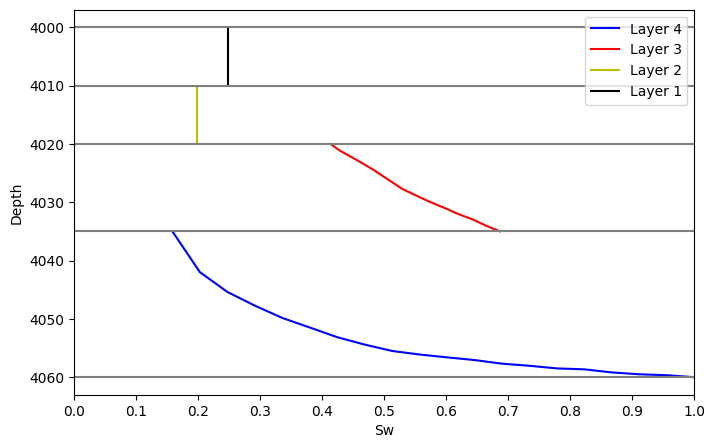

In [26]:
## Final Plotting : - >

plt.figure(figsize=(8,5))
plt.plot(df_4['Sw_4'], df_4['Depth_Layer4'] , color = 'b', label = 'Layer 4')
plt.plot(df_4['Sw_3'], df_4['Depth_Layer3'] , color = 'r', label = 'Layer 3')
plt.plot(df_4['Sw_2'], df_4['Depth_Layer2'] , color = 'y', label = 'Layer 2')
plt.plot(df_4['Sw_1'], df_4['Depth_Layer1'] , color = 'k', label = 'Layer 1')
plt.hlines(y=df_1['Top'][0], xmin=0, xmax=1, color='gray')
plt.hlines(y=df_1['Top'][1], xmin=0, xmax=1, color='gray')
plt.hlines(y=df_1['Top'][2], xmin=0, xmax=1, color='gray')
plt.hlines(y=df_1['Top'][3], xmin=0, xmax=1, color='gray')
plt.hlines(y=df_1['Bottom'][3], xmin=0, xmax=1, color='gray')
plt.xlabel('Sw')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.legend()
plt.xlim(left=0,right=1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()


### Final Conclusion :

> Since the graph b/w Depth and Sw is vertically straight , This means that this Zone produces only oil and since water is present at it's connate water saturation so it can't flow . So both Layers 1 and 2 are oil producing .

> While Layer's 3 and 4 come under Transition zone . Produce Both Oil and Water . So not very economical as water treatment is costly .

